In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

In [2]:
price = pd.read_csv('MSN.csv')
price['Close'] = price['Close'].astype('float64')
returns = 100*price['Close'].pct_change().dropna()

Text(0.5, 1.0, 'Returns')

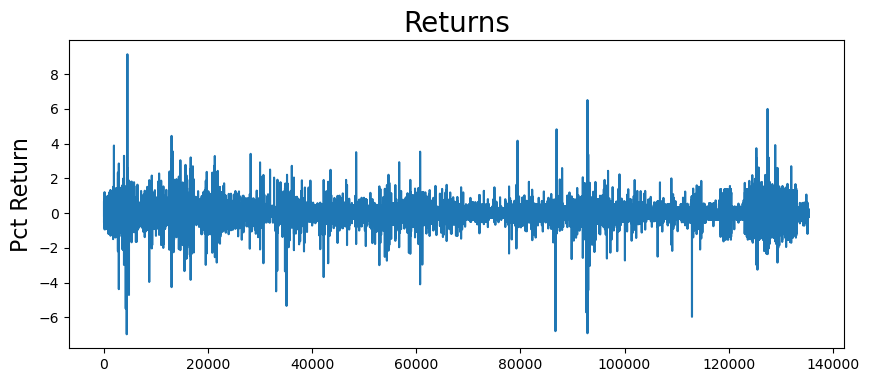

In [3]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title('Returns', fontsize=20)

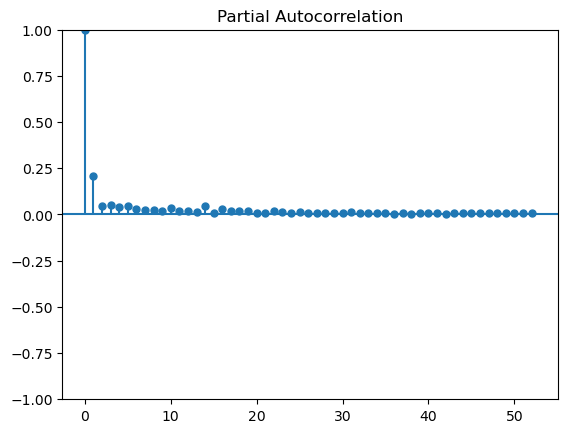

In [4]:
plot_pacf(returns**2)
plt.show()

In [5]:
#Fit GARCH

# Khởi tạo và ước lượng mô hình GARCH(1,1)
# Không thực hiện rescale, vô hiệu hóa cảnh báo
model = arch_model(returns, vol='Garch', p=1, q=1, mean='Zero', dist='normal', rescale=False)  # mean='Zero' cho mô hình chỉ xét volatility
model_fit = model.fit()

Iteration:      1,   Func. Count:      4,   Neg. LLF: -27400.118170478025
Optimization terminated successfully    (Exit mode 0)
            Current function value: -27400.118601969356
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


In [6]:
# Hiển thị kết quả
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                27400.1
Distribution:                  Normal   AIC:                          -54794.2
Method:            Maximum Likelihood   BIC:                          -54764.8
                                        No. Observations:               135353
Date:                Sun, Nov 17 2024   Df Residuals:                   135353
Time:                        16:04:26   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.4926e-03  2.104e-04      7.094  1.302e-12 [1.080e-03,1.905e-03]
alpha[1]       0.1000  7.891e-03     12.672  8.449e-37   [8.453e-02,  0.115]
beta[1]        0.8800  6.211e-03    141.684      0.000     [  0.868,  0.892]
============================================================================

Covariance estimator: robust
"""

In [7]:
returns.index = pd.date_range(start='2017-12-25 09:15:00', periods=len(returns),freq='T')
rolling_predictions = []
test_size = 400 #400 for faster test 
for i in range(test_size):
    # Tạo tập huấn luyện
    train = returns[:-(test_size - i)]
    # Định nghĩa và huấn luyện mô hình GARCH(1,1)
    model = arch_model(train, p=1, q=1, mean='Zero', dist='normal', rescale=False)
    model_fit = model.fit(disp='off')
    # Dự báo 1 bước
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1, :][0]))  # Lấy căn bậc 2 phương sai dự báo
# Chuyển danh sách
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-400:])

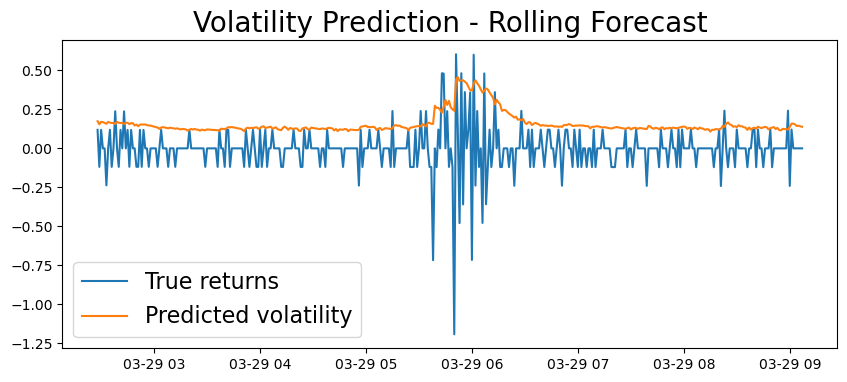

In [8]:
plt.figure(figsize=(10,4))
plt.plot(returns[-400:], label='True returns')
plt.plot(rolling_predictions, label='Predicted volatility')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(fontsize = 16)


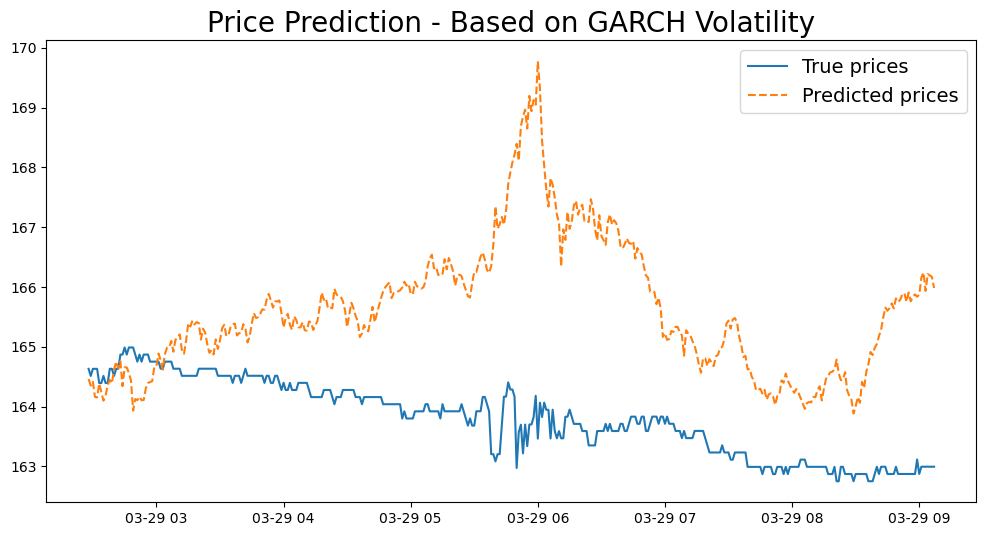

In [8]:

# Dataset: Giả sử 'prices' là chuỗi giá cổ phiếu với index là thời gian
prices = returns.cumsum() + 100  # Tạo chuỗi giá giả lập từ returns để minh họa
returns.index = prices.index

# Thêm bước dự báo biến động giá dựa trên GARCH dự báo
rolling_predictions_price = []
current_price = prices.iloc[-test_size - 1]  # Giá bắt đầu từ trước chuỗi dự báo

for i in range(test_size):
    volatility = rolling_predictions.iloc[i]  # Dự báo volatility từ GARCH
    # Mô phỏng biến động giá từ phân phối chuẩn
    price_change = np.random.normal(0, volatility)
    current_price += price_change
    rolling_predictions_price.append(current_price)

# Chuyển sang Series
rolling_predictions_price = pd.Series(rolling_predictions_price, index=prices.index[-test_size:])

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(prices[-test_size:], label='True prices')
plt.plot(rolling_predictions_price, label='Predicted prices', linestyle='--')
plt.title('Price Prediction - Based on GARCH Volatility', fontsize=20)
plt.legend(fontsize=14)
plt.show()

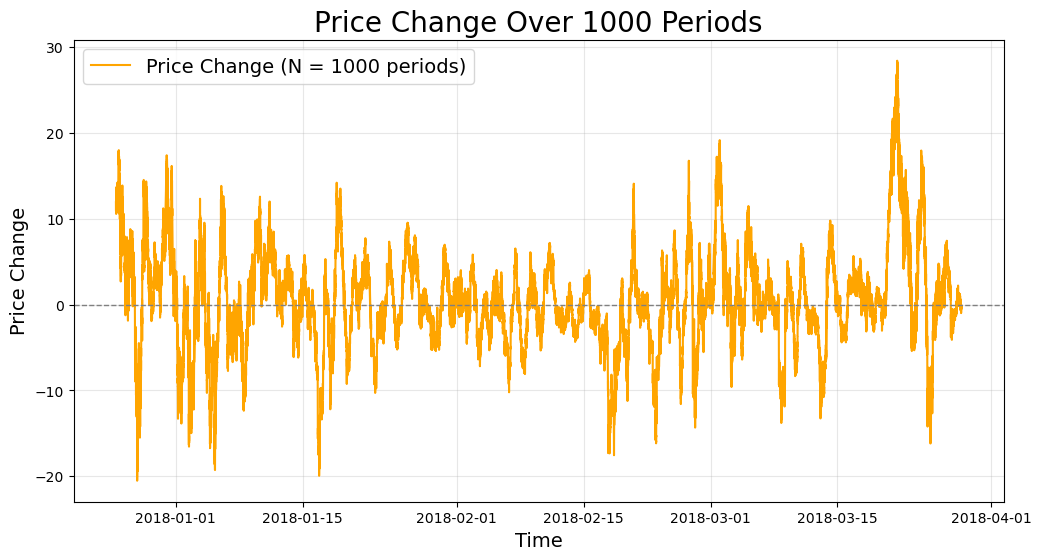

In [9]:

# Thời gian N (khoảng cách dự báo)
N = 1000  # Số phút sau

# Tính biến động giá (Delta P)
delta_price = prices.shift(-N) - prices

# Loại bỏ giá trị NaN do shift
delta_price = delta_price.dropna()

# Biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(delta_price, label=f'Price Change (N = {1000} periods)', color='orange')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Đường ngang tại y=0
plt.title(f'Price Change Over {N} Periods', fontsize=20)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Price Change', fontsize=14)
plt.legend(fontsize=14)
plt.grid(alpha=0.3)
plt.show()